# Предисловие: 

Поскольку я в большей степени ориентировался на построение модели и выполнение задачи, то случаи выбросов я буду просто отбрасывать без дальнейшего анализа. Ясно, что в реальном анализе такое не допустимо, но здесь ограничимся этим.

Также в требовании была указана единая тетрадка, хотя изначально я делал разбиения на модули. Из за этого тетрадка не до конца целостная. Например, где то присутствует type hinting и docstring, а где то приходится повторно загружать датафрейм, чтобы можно было сохранить разбиение тетради на логические части.

In [1]:
import itertools
import pickle
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch.nn.utils.rnn import (PackedSequence, pack_padded_sequence,
                                pad_packed_sequence)
from torch.utils.data import DataLoader, Dataset

# Загрузим и предобработаем данные

In [33]:
df = pd.read_excel('data.xlsb', engine='pyxlsb').drop(['ID ЗАКАЗА'], axis=1)

In [34]:
with open('data.pickle', 'wb') as f:
    pickle.dump(df, f)

In [3]:
df = df.rename({'ДАТА ЗАКАЗА': 'date', 
                'СУММА ЗАКАЗА': 'sum', 
                'ID КЛИЕНТА': 'user_id',
                'НАЗВАНИЕ КУПОНА': 'coup',
                'НАИМЕНОВАНИЕ АКЦИИ': 'prom'}, axis=1)

* Посмотрим на заполненность таблицы

In [4]:
df.isna().sum()

date           0
sum            0
user_id        0
coup       50044
prom       50022
dtype: int64

Видно, что в основном никто не пользуется акциями, но я все равно в дальнейшем попробую вытащить оттуда информацию

* Построим гистограмму суммы заказов

<AxesSubplot:>

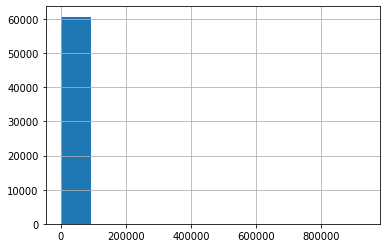

In [5]:
df['sum'].hist()

Присутствуют явные выбросы. Отбросим такие транзакции.

<AxesSubplot:>

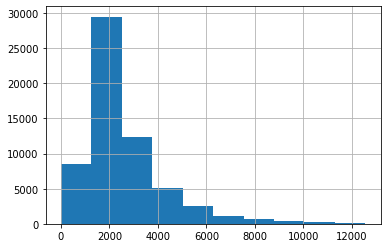

In [6]:
df = df[(df['sum'] - df['sum'].mean()) < df['sum'].std() * 2]
df['sum'].hist()

Так намного лучше.

* Посмотрим на даты

<AxesSubplot:>

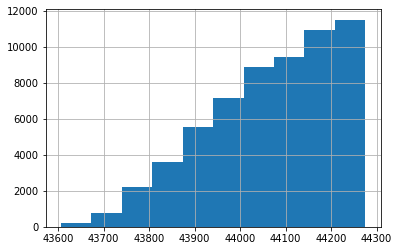

In [7]:
df['date'].hist()

Пусть точкой отсчета дат транзакций для кажого пользователя будет 0.

При таком условии, мы будем считать каждую первую покупку пользователя независимой от времени и сезона. Делаю это в надежде на лучшую обобщающую способность системы. Также т.к. даты смещены к концу, то это поможет избежать переобучения на последние даты.

In [8]:
def add_rel_dates(df):
    # Создание относительной даты.
    clients_date = df.groupby('user_id')['date'].agg(lambda x: x.tolist()).to_dict()
    first_order = df.groupby('user_id')['date'].min().to_dict()
    for k, v in clients_date.items():
        clients_date[k] = [(date - first_order[k]) for date in v]
    user_date_tuples = []
    for k, v in clients_date.items():
        for date in v:
            user_date_tuples.append((k, date))

    df_normed = pd.DataFrame(user_date_tuples, columns=['user_id', 'rel_date'])

    df_normed = df_normed.sort_values(by=['user_id', 'rel_date'], ignore_index=True)
    df = df.sort_values(by=['user_id', 'date'], ignore_index=True)

    df['rel_date'] = df_normed['rel_date']
    return df, first_order

<AxesSubplot:>

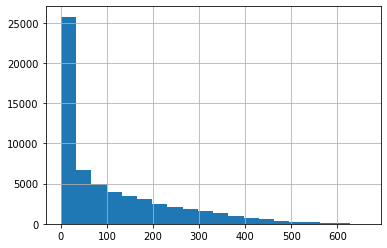

In [9]:
df, first_order = add_rel_dates(df)
df['rel_date'].hist(bins=20)

Способ востановления исходной даты:

In [10]:
def origin_date(first_order, rel_date):
    return first_order + rel_date

assert origin_date(first_order[1], df['rel_date'][2]) == df['date'][2]

* Вытащим признаки из наименования акции: скидка и на какой по счету заказ распространяется акция

In [11]:
def get_features(line):
    if isinstance(line, str):
        line = line.lower()
        end_of_prise = line.find('руб')
        discount = line[:end_of_prise].split()[-1]
        if discount.isdigit():
            discount = int(discount)
        else:
            discount=0

        order_dict = {
            'первый': 1, 
            '1-ый': 1,
            # Сомнительно, но если так сделать, то будет порядок.
            'следующий': 1,
            'второй': 2, 
            '2-ой': 2,
            'третий': 3,
        }
        order = 0
        for k in order_dict.keys():
            if k in line:
                order = order_dict[k]
        return discount, order
    else:
        return 0, 0

In [12]:
prom_features = df['prom'].apply(get_features)
df[['disc', 'disc_order']] = pd.DataFrame(prom_features.tolist(),
                                          columns=['disc', 'disc_order'],
                                          index=prom_features.index)

* Выкинем лишние столбики и поменяем оставшиеся местами для удобства

In [13]:
df = df.drop(['date', 'coup', 'prom'], axis=1)
df = df.reindex(columns=['user_id', 'rel_date', 'sum', 'disc', 'disc_order'])

In [14]:
df.head()

,user_id,rel_date,sum,disc,disc_order
0,1,0,1.00,0,0
1,1,147,2438.00,0,0
2,1,262,6164.96,0,0
3,5,0,429.66,0,0
4,5,45,4432.49,0,0


* Приведем данные к векторам и разобьем их на train и test.

Нормализуем данные

In [15]:
min_max_scaler = MinMaxScaler()
df[['rel_date', 'sum', 
    'disc', 'disc_order']] = min_max_scaler.fit_transform(df[['rel_date', 'sum',
                                                              'disc', 'disc_order']])

min_values = min_max_scaler.data_min_
max_values = min_max_scaler.data_max_

Отсортируем и сгруппируем данные по `user_id`. Таким образом на выходе будут последовательности признаков пользователей в исходном порядке

In [16]:
df = df.sort_values(by=['user_id', 'rel_date'])
grouped_df = df.groupby('user_id').agg(lambda x: x.tolist())

Проиндексируем пользователей и применим индексацию

In [17]:
# -1 это абстрактный pad токен.
idx2user = [-1] + grouped_df.index.tolist()
user2idx = {u: i for i, u in enumerate(idx2user)}

grouped_df.index = grouped_df.index.map(user2idx)

Функция для фильтрации максимальной и минимальной длины последовательности на обучении.

In [18]:
MIN_SEQ_LEN = 3
MAX_SEQ_LEN = 50

def filter_seq(seq, min_seq_len, max_seq_len):
    if len(seq) >= min_seq_len and len(seq) <= max_seq_len:
        return seq
    else:
        return None

Теперь отфильтруем последовательности по длине

In [19]:
grouped_df['rel_date'] = grouped_df['rel_date'].apply(lambda x: filter_seq(x, MIN_SEQ_LEN, MAX_SEQ_LEN))
grouped_df = grouped_df.dropna()

Приведем данные к векторному виду и запишем максимальную длину последовательстей

In [20]:
max_len = 0
data = []
for row in grouped_df.itertuples(name=None):
    seq_len = len(row[1])
    features = np.array([[row[0]] * seq_len] + list(row[1:])).T
    if seq_len > 2 and seq_len <= 50:
        if max_len < seq_len:
            max_len = seq_len
        data.append(features)

Вот так выглядят наше векторное представление

In [21]:
data[:2]

[array([[1.00000000e+00, 0.00000000e+00, 7.96848941e-05, 0.00000000e+00,
         0.00000000e+00],
        [1.00000000e+00, 2.22390318e-01, 1.94271772e-01, 0.00000000e+00,
         0.00000000e+00],
        [1.00000000e+00, 3.96369138e-01, 4.91254184e-01, 0.00000000e+00,
         0.00000000e+00]]),
 array([[2.        , 0.        , 0.03423741, 0.        , 0.        ],
        [2.        , 0.06807867, 0.3532025 , 0.        , 0.        ],
        [2.        , 0.0892587 , 0.23522104, 0.        , 0.        ],
        [2.        , 0.15582451, 0.09764188, 0.        , 0.        ],
        [2.        , 0.1785174 , 0.15233839, 0.        , 0.        ],
        [2.        , 0.29046899, 0.36872033, 0.        , 0.        ],
        [2.        , 0.30408472, 0.17961772, 0.        , 0.        ],
        [2.        , 0.3419062 , 0.10810451, 0.        , 0.        ],
        [2.        , 0.35098336, 0.22918093, 0.        , 0.        ],
        [2.        , 0.37065053, 0.25429442, 0.        , 0.        ],
 

* Создам свое разбиение выборки на `train` и `test`. Далее я обьясняю каким образом происходит разбиение и почему

In [22]:
def train_test_split(data):
    train_inp = []
    train_target = []
    test_inp = []
    test_target = []

    for features in data:
        train_inp.append(features[:-2])
        test_inp.append(features[:-1])
        train_target.append(features[1: -1, 1])
        test_target.append(np.array([features[-1, 1]]))
        
    return (train_inp, train_target), (test_inp, test_target)

# Обучение, создание классов загрузки данных.

* Cоберу все что было выше в единый класс, чтобы в дальнейшем им было удобно пользоваться.

In [23]:
class DataTransformer:
    def transform(self, df, min_seq_len=3, max_seq_len=50, is_inference=False):
        df = df.rename({'ДАТА ЗАКАЗА': 'date', 
                        'СУММА ЗАКАЗА': 'sum', 
                        'ID КЛИЕНТА': 'user_id',
                        'НАЗВАНИЕ КУПОНА': 'coup',
                        'НАИМЕНОВАНИЕ АКЦИИ': 'prom'}, axis=1)
        
        if is_inference:
            min_seq_len = 0
            max_seq_len = 100000
        else:
            outlier_map = (df['sum'] - df['sum'].mean()) > df['sum'].std() * 2
            self.outlier_users = df[outlier_map].user_id.tolist()
            df = df[~outlier_map]
        
        df = self._add_rel_dates(df)
        
        prom_features = df['prom'].apply(get_features)
        df[['disc', 'disc_order']] = pd.DataFrame(prom_features.tolist(),
                                                  columns=['disc', 'disc_order'],
                                                  index=prom_features.index)
        
        df = df.drop(['date', 'coup', 'prom'], axis=1)
        df = df.reindex(columns=['user_id', 'rel_date', 'sum', 'disc', 'disc_order'])
        data = self._setup_data(df, is_inference, min_seq_len, max_seq_len)
        return data
    
    def train_test_data(self, df):
        data = self.transform(df)
        return train_test_split(data)
    
    def _add_rel_dates(self, *args):
        df, self.first_order = add_rel_dates(*args)
        return df
        
    def _setup_data(self, df, is_inference, min_seq_len, max_seq_len):
        # Если датасет используется для обучения, то обучаем min max scaler
        if not is_inference:
            self.min_max_scaler = MinMaxScaler()
            self.min_max_scaler.fit(df[['rel_date', 'sum', 'disc', 'disc_order']])
            self.min_date = self.min_max_scaler.data_min_[0]
            self.max_date = self.min_max_scaler.data_max_[0]
        df[['rel_date', 'sum', 
            'disc', 'disc_order']] = self.min_max_scaler.transform(df[['rel_date', 'sum', 
                                                                       'disc', 'disc_order']])
        # сортируем, чтобы при группировке даты шли в возрастающем порядке
        df = df.sort_values(by=['user_id', 'rel_date'])
        # Группируем датафрейм по клиентам. В каждом столбике будут последовательности.
        grouped_df = df.groupby('user_id').agg(lambda x: x.tolist())
        # Если датасет используется для обучения, то индексируем клиентов.
        if not is_inference:
             # -1 это абстрактный pad токен. -42 - токен юзеров, которые не участвовали в обучении.
            self.idx2user = [-1] + grouped_df.index.tolist() + self.outlier_users
            self.user2idx = {u: i for i, u in enumerate(self.idx2user)}
        # Меняем ID клиентов на индексы.
        grouped_df.index = grouped_df.index.map(self.user2idx)
        # Если датасет используется для обучения, то отбрасываем маленькие и большие последовательности.
        if not is_inference:
            grouped_df['rel_date'] = grouped_df['rel_date'].apply(lambda x: filter_seq(x, min_seq_len, max_seq_len))
            grouped_df = grouped_df.dropna()
        # Если датасет используется для инференса, 
        # то заполняем неиндексированных пользователей специальным токеном
        else:
#             grouped_df.index = grouped_df.index.fillna(self.user2idx[-42])
            grouped_df = grouped_df.fillna(0)
            
        # Создаем векторы для обучения, находим максимальную длину последовательности.
        self.max_len = 0
        data = []
        for row in grouped_df.itertuples(name=None):
            seq_len = len(row[1])
            features = np.array([[row[0]] * seq_len] + list(row[1:])).T
            if self.max_len < seq_len:
                self.max_len = seq_len
            data.append(features)
        
        return data
    
    def get_origin_date(self, user_id, date):
        user_id = self.idx2user[user_id]
        rel_date = (date * (self.max_date - self.min_date) + self.min_date)
        return self.first_order[user_id] + rel_date

## Построение модели и итератора по данным.
В качестве базы для ML модели я взял LSTM rnn.

Модель будет учится предсказывать следующую дату заказа по следующим данным:

`ID клиента, дата предыдущего заказа, сумма предыдущего заказа, скидка по купону, на какой заказ по счету распространяется скидка`

Не стал как то комментировать эти пункты в markdown. Это был отдельный модуль, в котором я заранее решил все закомменировать в docstring-ах.

In [24]:
# ==== utils ==== #

def pad_sequence(array: np.array, max_len: int, pad_idx: int) -> np.array:
    """
    Прибавляет к последовательности pad токены
    """
    dim = len(array.shape)
    shape = (max_len - array.shape[0], *array.shape[1:])
    padding_array = np.full(shape, pad_idx)
    if dim > 1:
        return np.vstack((array, padding_array))
    else:
        return np.hstack((array, padding_array))

def shift_range(range_list: list, shift: int) -> list:
    """
    shift_range([1, 3, 4], 5) -> 
            [0, 0+5, 1+5, 2+5, 0 + 2*5, 1 + 2*5, 2 + 2*5, 3 + 2*5]
    """
    res = []
    for i, r in enumerate(range_list):
        res.extend(list(range(i*shift, r + i*shift)))
    return res

def flat_packed_sequence(packed_sequence: PackedSequence) -> torch.Tensor:
    """
    Преобразует запакованную последовательность в плоский тензор(без паддинга), 
    который меньше на одну размерность.
    """
    padded_sequence, seq_lens = pad_packed_sequence(packed_sequence, batch_first=True)
    seq_lens = seq_lens.tolist()
    non_pad_indexes = shift_range(seq_lens, max(seq_lens))
    flat_sequence = padded_sequence.view(-1, padded_sequence.size(2))
    flat_sequence = flat_sequence[non_pad_indexes]
    return flat_sequence

def flat_padded_sequence(pad_sequence: torch.Tensor, seq_lens: list) -> torch.Tensor:
    """
    Преобразует теноз с паддингом в плоский тензор,
    который меньше на одну размерность.
    """
    packed_sequence = pack_padded_sequence(pad_sequence, seq_lens, batch_first=True, enforce_sorted=False)
    return flat_packed_sequence(packed_sequence)

# ==== Classes ==== #

class RNNDataset(Dataset):
    """
    Класс, преобразующий входные данные в 
    данные, которые способна принимать на вход
    модель.
    """
    def __init__(self, inp: list, target: list, max_len: int, 
                 pad_idx: int=0, stage: str='fit') -> None:
        """stage: [fit, validate, inference]"""
        self.stage = stage
        self.inp = inp
        if stage != 'inference':
            self.target = target
        self.max_len = max_len
        self.pad_idx = pad_idx
    
    def __len__(self):
        return len(self.inp)
        
    def __getitem__(self, idx: int) -> dict:
        data = dict()
        
        inp = self.inp[idx]
        seq_len = inp.shape[0]
        inp = pad_sequence(inp, self.max_len, self.pad_idx)

        user_id = inp[:, 0]
        feature = inp[:, 1:]
        
        if self.stage != 'inference':
            target = self.target[idx]
        if self.stage == 'fit':
            target = pad_sequence(target, self.max_len, self.pad_idx)
        
        data = {
            'user_id': torch.LongTensor(user_id),
            'feature': torch.FloatTensor(feature),
            'inp_len': torch.tensor(seq_len)
        }
        
        if self.stage != 'inference':
            data['target'] = torch.FloatTensor(target).reshape(-1,1)
        
        return data


class RNNModel(nn.Module):
    """
    Рекурентная модель для предсказания следующий даты покупки.
    ID пользователя преобразуется в вектор с помощью nn.Emdedding,
    остальные признаки конкатинируются с полученным вектором.
    Далее подается на вход LSTM сети.
    """
    def __init__(self, vocab_size: int, hidden_size: int, n_layers: int, 
                 emb_size: int, pad_idx: int) -> None:
        super().__init__()
#         self.max_len = max_len
        self.emb_size = emb_size
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.emb = nn.Embedding(num_embeddings=vocab_size, 
                                embedding_dim=emb_size,
                                padding_idx=pad_idx)

        # self.norm = nn.BatchNorm1d(max_len)

        input_size = 4 + emb_size
        self.rnn = nn.LSTM(input_size,
                           hidden_size,
                           batch_first=True,
                           num_layers=n_layers)

        self.dense = nn.Linear(hidden_size, 1)
        
    def forward(self, user_id: torch.Tensor, feature: torch.Tensor, 
                inp_len: torch.Tensor) -> torch.Tensor:
        batch_size = user_id.size(0)
        
        user_emb = self.emb(user_id)
        x = torch.cat((user_emb, feature), 2)
        # x = self.norm(x)
        x = pack_padded_sequence(x, inp_len.cpu(), batch_first=True, enforce_sorted=False)

        state = self._normal_state(batch_size)

        x, _ = self.rnn(x, state)
        x = flat_packed_sequence(x)
        
        x = self.dense(x)
        return x
    
    def _normal_state(self, batch_size: int) -> Union[torch.Tensor, tuple]:
        """
        Генерирует начальное состояние для сети.
        """
        device = next(self.dense.parameters()).device
        if not isinstance(self.rnn, nn.LSTM):
            return torch.normal(0, 1, (self.n_layers, batch_size, self.hidden_size)).to(device)
        else:
            return (torch.normal(0, 1, (self.n_layers, batch_size, self.hidden_size)).to(device),
                    torch.normal(0, 1, (self.n_layers, batch_size, self.hidden_size)).to(device))


## Метод обучения

В качестве функции ошибки я взял `MSE`. Потому что она совпадает с целевой метрикой.

In [25]:
def train(num_epoch, train_loader, model, optimizer, device):
    model.to(device)
    model.train()
    history=[]
    for i in range(num_epoch):
        for j, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            user_id = batch['user_id'].to(device)
            feature = batch['feature'].to(device)
            inp_len = batch['inp_len']
            
            logits = model(user_id, feature, inp_len)
            target = flat_padded_sequence(batch['target'], inp_len).to(device)
            
            loss = F.mse_loss(logits, target)
            loss.backward()
            optimizer.step()
            
            history.append(loss.item())
    return history

## Метод тестирования

Тестирование будет заключаться в предсказание даты последнего заказа.
В качестве метрики будет брать RMSE по всем предсказаниям. Т.е. значение метрики - на сколько дней мы в среднем ошибаемся.

Хотя это можно оценивать и подругому, но я выбрал именно такую метрику исходя из формулировки задачи. Мне нужно предсказывать следующую дату покупки, значит стоит прицеливаться именно на последнюю дату.

In [26]:
def origin_date(rel_date, min_date, max_date):
    return int(rel_date * (max_date - min_date) + min_date)

def convert_dates(dates, min_date, max_date):
    origin_dates = []
    for d in dates:
        origin_dates.append(
                    origin_date(d, min_date, max_date)
        )
    return origin_dates

def test(test_loader, model, device, min_date, max_date):
    model.to(device)
    model.eval()
    errors = []
    with torch.no_grad():
        for j, batch in enumerate(test_loader):
            user_id = batch['user_id'].to(device)
            feature = batch['feature'].to(device)
            inp_len = batch['inp_len']
            
            last_els = [x-1 for x in itertools.accumulate(inp_len.tolist())]
            logits = model(user_id, feature, inp_len)[last_els]
            
            target = batch['target'].reshape(-1).tolist()
            logits = logits.reshape(-1).tolist()
            
            pred = convert_dates(logits, min_date, max_date)
            true = convert_dates(target, min_date, max_date)
            
            error = F.mse_loss(torch.FloatTensor(pred), torch.FloatTensor(true), reduction='none')
            errors.extend(error.reshape(-1).tolist())

    return np.mean(errors) ** 0.5

# Наконец иницилизируем итератор и модель, обучаемся

In [27]:
df = pd.read_excel('data.xlsb', engine='pyxlsb').drop(['ID ЗАКАЗА'], axis=1)

dt = DataTransformer()
(train_inp, train_target), (test_inp, test_target) = dt.train_test_data(df)

train_dataset = RNNDataset(train_inp, train_target, dt.max_len)
train_loader = DataLoader(train_dataset, batch_size=4000, shuffle=True)

test_dataset = RNNDataset(test_inp, test_target, dt.max_len, stage='validate')
test_loader = DataLoader(test_dataset, batch_size=256)

In [28]:
model = RNNModel(vocab_size=len(dt.idx2user),
                 hidden_size=512,
                 n_layers=2,
                 emb_size=1024,
                 pad_idx=train_dataset.pad_idx)
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# 90 на 30 эпохе

In [30]:
epoch = 5000
val_each_step = 10

history = []
test_scores = []
for i in range(epoch // val_each_step + 1):
    history_ = train(val_each_step, train_loader, model, optimizer, device)
    history.append(sum(history_) / len(history_))
    
    test_score = test(test_loader, model, device, dt.min_date, dt.max_date)
    test_scores.append(test_score)
    
    clear_output(wait=True)
            
    fig, ax = plt.subplots(ncols=2, figsize=(18,5))

    ax[0].plot(history)
    ax[0].set_title('loss')

    ax[1].plot(test_scores)
    ax[1].set_title('test_scores')
    
    plt.show()

KeyboardInterrupt: 

# Предсказание оттока

Загрузим все имеющиеся данные и пропустим через модель

In [ ]:
df = pd.read_excel('data.xlsb', engine='pyxlsb').drop(['ID ЗАКАЗА'], axis=1)
data = dt.transform(df, is_inference=True)

inference_dataset = RNNDataset(inp=data, target=None, max_len=dt.max_len, stage='inference')
inference_loader = DataLoader(inference_dataset, batch_size=1)

In [ ]:
def predict(dataloader, model, device):
    users = []
    predictions = []
    for j, batch in enumerate(dataloader):
        user_id = batch['user_id'].to(device)
        feature = batch['feature'].to(device)
        inp_len = batch['inp_len']
        
        last_els = [x-1 for x in itertools.accumulate(inp_len.tolist())]

        logits = model(user_id, feature, inp_len)[last_els]
        
        users.extend(user_id[:, 0].tolist())
        predictions.extend(logits.reshape(-1).tolist())
        
    return users, predictions

In [ ]:
model.eval()
with torch.no_grad():
    predictions = predict(inference_loader, model, device)

Переведем выходы модели в исходные, ненормализованные даты

In [ ]:
user_next_date = []
for user_id, rel_date in zip(*predictions):
    date = dt.get_origin_date(user_id, rel_date)
    user_next_date.append((dt.idx2user[user_id], date))

In [ ]:
model_prediction = pd.Series([el[1] for el in user_next_date], index=[el[0] for el in user_next_date])

In [ ]:
model_prediction

Теперь у нас наконец есть даты предсказания следующей покупки. 

Дальше при имеющихся данных можно по разному оценить отток. Можно построить когорты и оценить вероятность возврата пользователя через какой то период. Можно построить поверх еще одну модельку, которая уже будет оценивать не следующую дату покупки, а склонность к оттоку.

Но в рамках этого тестового задания я ограничусь самыми простыми статистиками.

К предсказанию следующей даты мы прибавим среднюю ошибку модели `predict + error`. Далее найдем максимальный интервал бездействия пользователя `user_max_inactivity`. Возьмем максимум `max(user_max_inactivity, predict + error)`. Если пользователь бездействует в течении этого времени - он склонен к оттоку. Если пользователь после этой даты бездействует больше, чем обычно бездействуют перед тем, как воспользовались купоном на следующий заказ, то пользователи в оттоке. Последний пункт следует из гипотезы о том, что купон на следующий заказ дают пользователям, которые были склонны к оттоку (что вообще говоря неверно). Сколько обычно бездействуют будем считать как 2 среднекватратичных отклонения (чтобы наверняка уловить эту обыденность)

In [ ]:
# Подсчет максимального интервала между покупками
def max_inactivity(order_dates):
    delta = []
    if len(order_dates) > 1:
        for i in range(1, len(order_dates)):
            delta.append(order_dates[i] - order_dates[i-1])
    else:
        delta = [0]
        
    return max(delta)

# Подсчет даты последнего заказа
def last_order(order_dates):
    return order_dates[-1]

In [ ]:
df = df[['ДАТА ЗАКАЗА', 'ID КЛИЕНТА', 'НАИМЕНОВАНИЕ АКЦИИ']].rename({'ДАТА ЗАКАЗА': 'date',
                                                                    'ID КЛИЕНТА': 'user_id',
                                                                    'НАИМЕНОВАНИЕ АКЦИИ': 'prom'}, axis=1)

In [ ]:
user_activity = df[['date', 'user_id', 'prom']].sort_values(by=['user_id', 'date'])
user_activity = user_activity.groupby('user_id').agg(lambda x: x.tolist())

Посчитаем максимальный интервал между покупок каждого пользователя

In [ ]:
user_max_inactivity = user_activity['date'].apply(max_inactivity)

Найдем дату последнего заказа каждого пользователя

In [ ]:
user_last_order = user_activity['date'].apply(last_order)

И теперь посчитаем максимальную дату, до которой пользователь лояльные и не склонен к оттоку

In [ ]:
last_loyal_dates = []
for i in model_prediction.index:
    last_loyal_dates.append(max(model_prediction[i], user_last_order[i] + user_max_inactivity[i]))
loyal_date = pd.Series(last_loyal_dates, index=model_prediction.index)

Если еще не наступила дата, после которой считаем, что пользователь склонен к оттоку - он лояльный

In [ ]:
# Максимальная дата в выборке
max_date = df['date'].max()

In [ ]:
loyal_users = loyal_date[loyal_date >= max_date].index.tolist()

Теперь найдем пользователей, которые вернулись, воспользовавшись акцией, которой возвращают пользователя.

In [ ]:
# Является ли данная акция 'возвращающей'
def next_order_prom(line):
    if isinstance(line, str):
        orders = ['следующий', 'второй', '2-ой', 'третий']
        
        for o in orders:
            if o in line:
                return True
    return False

In [ ]:
df['prom'] = df['prom'].apply(next_order_prom)

In [ ]:
user_activity = df[['date', 'user_id', 'prom']].sort_values(by=['user_id', 'date'])
user_activity = user_activity.groupby('user_id').agg(lambda x: x.tolist())

Посчитаем время, которое прошло до того, как пользователи воспользовались "возвращающим" промокодом

In [ ]:
retantion_delta = []
for user, date, prom in user_activity.itertuples(name=None):
    for i in range(len(prom)):
        if prom[i] and i > 0:
            r_delta = date[i] - date[i-1]
            retantion_delta.append(r_delta)

Распределение

In [ ]:
retantion_delta = pd.Series(retantion_delta)
retantion_delta[retantion_delta < 100].hist()

Посчитаем 2 среднекватратичных отклонения

In [ ]:
max_retantion_time = retantion_delta.std() * 2

Найдем дату, после которой считается, что пользователь в оттоке.

In [ ]:
churn_date = loyal_date + max_retantion_time

Посчитаем пользователей в оттоке и склонных к оттоку

In [ ]:
churn_users = churn_date[(churn_date < max_date)].index.tolist()
prone_churn_users = churn_date[(churn_date >= max_date) & (loyal_date < max_date)].index.tolist()

Проверка, всех ли отнесли к той или иной группе

In [ ]:
assert (len(prone_churn_users) + len(churn_users) + len(loyal_users)) == len(user_activity)

`loyal_users` - лояльные пользователи

`prone_churn_users` - склонные к оттоку

`churn_users` - в оттоке 

Я не до конца понял, b2b клиенты предоставляют данные или мы делаем для них модель оттока. Перечислял исходя из полученных данных(в столбике "наименование акции" присутствует "для блогеров" и вряд ли они ищут работу) и задачи.
Список факторов, которые я бы использовал для построения модели оттока, если у меня есть возможность получить любую информацию о клиентах и их действиях:
* Конкретные даты покупок, а не условные таймстемпы
* Активность пользователей у конкурентов
* Глобальные и сезонные акции, которые запускает компания
* Когда какая рекламная кампания была развернута
* Статистика активности внутри приложения/сайта
* Характеристики товаров. Названия, тип и тд.
* Возраст, доход, род деятельности клиента
* Регион заказа
* Если это онлайн ритейл, то благоприятность погоды.